In [1]:
using LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: wheeler

include("../lib/gif.jl")

plot_animation (generic function with 1 method)

Optimum: [0.9912109375, 1.52001953125]


┌ Info: Saved animation to 
│   fn = /tmp/jl_letU7Y1oBi.gif
└ @ Plots /home/nguymin4/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_letU7Y1oBi.gif")
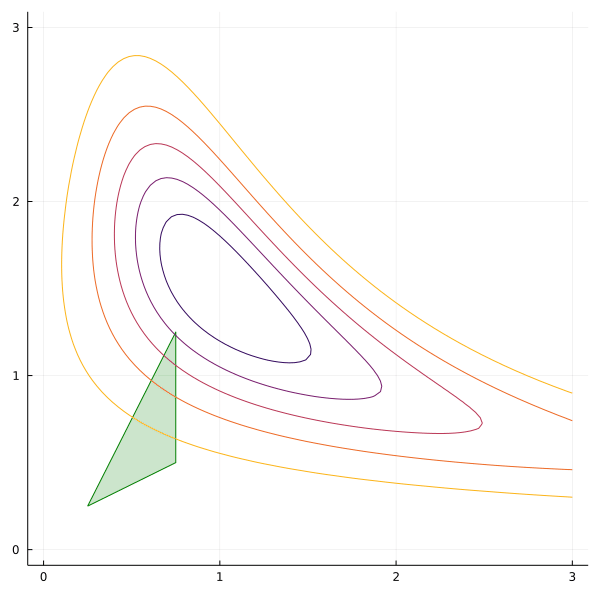

In [2]:
using Statistics

f, ∇f = wheeler(1.5)
xdomain = LinRange(0, 3, 100)
ydomain = LinRange(0, 3, 100)

plotsize = (360, 360)
blankplot = plt.plot(legend=false, grid=false, foreground_color_subplot=:white)

function plot_contour_and_simplex(simplex::Vector{Vector{Float64}}; size=plotsize)
  polygon = plt.Shape(
    [p[1] for p in simplex],
    [p[2] for p in simplex]
  )
  plot = plt.plot(polygon; size=size, linecolor=:green, fillcolor=:green, fillalpha=0.2, legend=false)
  plt.contour!(plot, xdomain, ydomain, (x, y) -> f([x, y]); colorbar=false, levels=5)
  return plot
end

function plot_subplots(S_history)
  subplots = [plot_contour_and_simplex(S) for S in S_history]
  N = 3
  M = ceil(Int64, length(subplots) / N)
  blank_subplots = repeat([deepcopy(blankplot)], M * N - length(subplots))
  plt.plot(
    subplots...,
    blank_subplots...,
    layout=plt.grid(M, N),
    size=plotsize .* (N, M)
  )
end

function nelder_mead(f, S; reflection_factor=1.0, expansion_factor=2.0, contraction_factor=0.5, shrinkage_factor=0.5, ϵ=1e-2, max_iteration=10)
  S_hist = [deepcopy(S)]
  Y = f.(S)
  for _ in 1:max_iteration
    idxs = sortperm(Y)
    S, Y = S[idxs], Y[idxs]
    x_h, y_h = S[end], Y[end]
    x_s, y_s = S[end-1], Y[end-1]
    x_l, y_l = S[1], Y[1]
    x_mean = mean(S[1:end-1])
    x_r = x_mean + reflection_factor * (x_mean - x_h)
    y_r = f(x_r)
    if y_r < y_l
      x_e = x_mean + expansion_factor * (x_r - x_mean)
      y_e = f(x_e)
      S[end], Y[end] = y_e < y_r ? (x_e, y_e) : (x_r, y_r)
    elseif y_r < y_s
      S[end], Y[end] = x_r, y_r
    else
      if y_r < y_h
        x_h, y_h = x_r, y_r
        S[end], Y[end] = x_r, y_r
      end
      x_c = x_mean + contraction_factor * (x_h - x_mean)
      y_c = f(x_c)
      if y_c > y_h
        S = [shrinkage_factor * (x + x_l) for x in S]
        Y = f.(S)
      else
        S[end], Y[end] = x_c, y_c
      end
    end

    push!(S_hist, deepcopy(S))
    if std(Y, corrected=false) <= ϵ
      break
    end
  end
  return S_hist, S[argmin(Y)]
end


S0 = [[0.25, 0.25], [0.75, 0.5], [0.75, 1.25]]
S_history, x = nelder_mead(f, S0; ϵ=1e-3, max_iteration=11)
println("Optimum: $x")
plot_animation(plot_contour_and_simplex, S_history)
# plot_subplots(S_history)